# Assessment for Catalytic Data Science, Inc.

## The goal of the challenge is to process the raw data files and perform some downstream analysis

The data contains information about the disease-gene associations from automatic text mining, manually curated literature, cancer mutation data, and genome-wide association studies. 

The confidence score presented indicated the reliability of different types and sources of evidence. 

The filtered data explicitly indicates the human gene nomenclature containing (HGNC) only gene families.

The goal is to use the graph database to see the connections between diseases and the corresponding genes. For this purpose, we can create two labeled nodes called "disease" and "gene". We can connect these nodes using the confidence scores and source scores. That way we can filter the reliable data that could indicate the connection. 


To begin with, we start with setting up neo4j for a new graph database. There are multiple ways to script the queries. One is using the neo4j desktop and the other way is using python combined with a cipher (with neo4j graph database connection parameters like host, username, and password). To use the jupyter notebook features in presenting the tables and graphs, I've chosen the second path using python/cipher.

Here is the list of tsv files:

* 1) human_disease_knowledge_filtered.tsv
* 2) human_disease_knowledge.tsv
* 3) human_disease_experiments_filtered.tsv
* 4) human_disease_experiments_full.tsv
* 5) human_disease_textmining_filtered.tsv
* 6) human_disease_textmining_full.tsv
* 7) human_disease_integrated_full.tsv

I've done the initial analysis for the filtered files in the following order: knowledge, experimnets, and mining. For the full (larger) files, we can just add the periodic loop calls to load the csv files in chunks. 

To begin with, we can start installing the neo4j and pandas python libraries

In [59]:
! pip install pandas
! pip install neo4j
! pip install ipywidgets
! pip install yfiles-jupyter-graphs
! pip install graphdatascience

I've created the graph database in neo4j. Here is a class to create the connection on the python end

In [60]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [64]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="cat1234567")
    

Now let's start with loading the smaller file data set (filtered) using the follwoing cipher query.

In [65]:
knowledge_filtered_u_nodes ="""
// we would like to create two types of nodes: 
// 1- gene node with these two properties: gene id (gi) and gene name (gn)
// 2- disease node with the following properties: disease id (di) and disease name (dn)
// we start with craeting the nodes with the unique ids
CREATE CONSTRAINT FOR (n:gene) REQUIRE  n.gi IS UNIQUE
CREATE CONSTRAINT FOR (n:disease) REQUIRE n.di IS UNIQUE;
"""

In [66]:
conn.query(knowledge_filtered_u_nodes)

Query failed: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'CREATE': expected "OPTIONS" or <EOF> (line 7, column 1 (offset: 323))
"CREATE CONSTRAINT FOR (n:disease) REQUIRE n.di IS UNIQUE;"
 ^}


In [75]:
knowledge_filtered ="""
LOAD CSV FROM "file:///c:/human_disease_knowledge_filtered.tsv" AS row
FIELDTERMINATOR '\t'
// NOTE regarding the header/keys
     //  GENE_IDENTIFIER:gi=row[0] , 
     //  GENE_NAME:gn= row[1] ,
     //  DISEASE_IDENTIFIER:di = row[2],
     //  DISEASE_NAME:dn=row[3],
     //  SOURCE_DATABASE:sd =row[4],
     //  EVIDENCE_TYPE:et=row[5],
     //  CONFIDENCE_SCORE:cs= toInteger(row[6])
MERGE (g:gene {gi:row[0], gn:row[1]})
WITH row , g
MERGE (d:disease {di:row[2], dn:row[3]})
WITH g,d,row
MERGE (g)-[k:knowledge{sd:row[4], et:row[5], cs:toInteger(row[6])}]->(d); 
"""
conn.query(knowledge_filtered)

We can count the distinct number of genes and diseases. For the filtered knowledge csv db, we have 1099 unique diseases and 3660 unique genes in the filtered knowledge file:

In [77]:
dis_disease_q  ='''
MATCH (dis:disease) 
RETURN count (DISTINCT dis)
'''
conn.query(dis_disease_q)

[<Record count (DISTINCT dis)=1099>]

In [78]:
dis_gene_q  ='''
MATCH (g:gene) 
RETURN count (DISTINCT g)
'''
conn.query(dis_gene_q)

[<Record count (DISTINCT g)=3660>]

Now we can plot the graph for the nodes and edges for the human_disease_knowledge_filtered.tsv

In [79]:
ne_knowledge_filtered ="""
MATCH n=(d:disease) <-[]-() 
RETURN Distinct n;
"""
conn.query(ne_knowledge_filtered )

[<Record n=<Path start=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:72' labels=frozenset({'disease'}) properties={'di': 'DOID:1928', 'dn': 'Williams-Beuren syndrome'}> end=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:3729' labels=frozenset({'gene'}) properties={'gi': 'ENSP00000378577', 'gn': 'CLDN3'}> size=1>>,
 <Record n=<Path start=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:72' labels=frozenset({'disease'}) properties={'di': 'DOID:1928', 'dn': 'Williams-Beuren syndrome'}> end=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:2331' labels=frozenset({'gene'}) properties={'gi': 'ENSP00000336740', 'gn': 'LIMK1'}> size=1>>,
 <Record n=<Path start=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:72' labels=frozenset({'disease'}) properties={'di': 'DOID:1928', 'dn': 'Williams-Beuren syndrome'}> end=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:2466' labels=frozenset({'gene'}) properties={'gi': 'ENSP00000342434', 'gn': 'BAZ1B'}>

In order to visualize 4759 nodes (diseases and gens combined) we need to change the numnber of nodes display threshold as follows:

In [88]:
q = '''
:config initialNodeDisplay:5000
'''
conn.query(q)


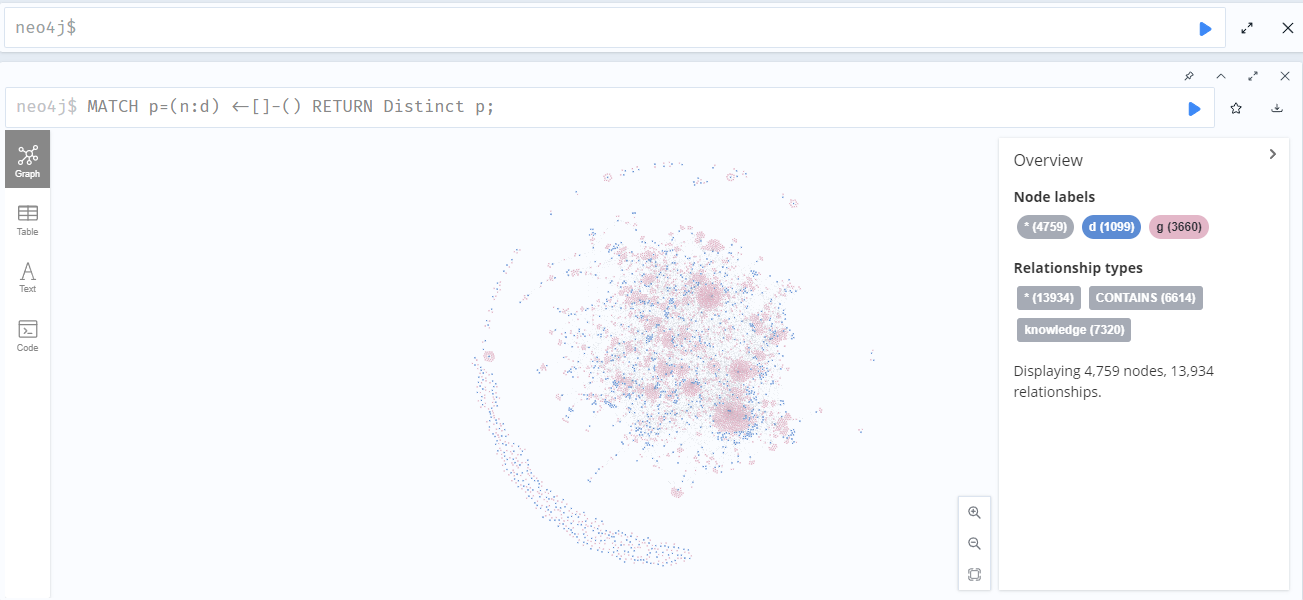

In [85]:
from IPython.display import Image
Image(filename='knowledge_filtered_0.png') 

Now we can play with the confidence score threshold. Let's display 5 unique diseases with the max confidence score


In [96]:
q ='''
 MATCH (d:disease)<-[k:knowledge]-() RETURN d.dn AS Disease_Name,
 AVG(toFloat(k.cs)) As AVG_Score
 ORDER BY AVG_Score DESC 
 LIMIT 5;
'''
conn.query(q)


[<Record Disease_Name='Ornithine carbamoyltransferase deficiency' AVG_Score=5.0>,
 <Record Disease_Name='Congenital bilateral absence of vas deferens' AVG_Score=5.0>,
 <Record Disease_Name='cytochrome-c oxidase deficiency disease' AVG_Score=5.0>,
 <Record Disease_Name='Coloboma' AVG_Score=5.0>,
 <Record Disease_Name='Schizophrenia' AVG_Score=5.0>]

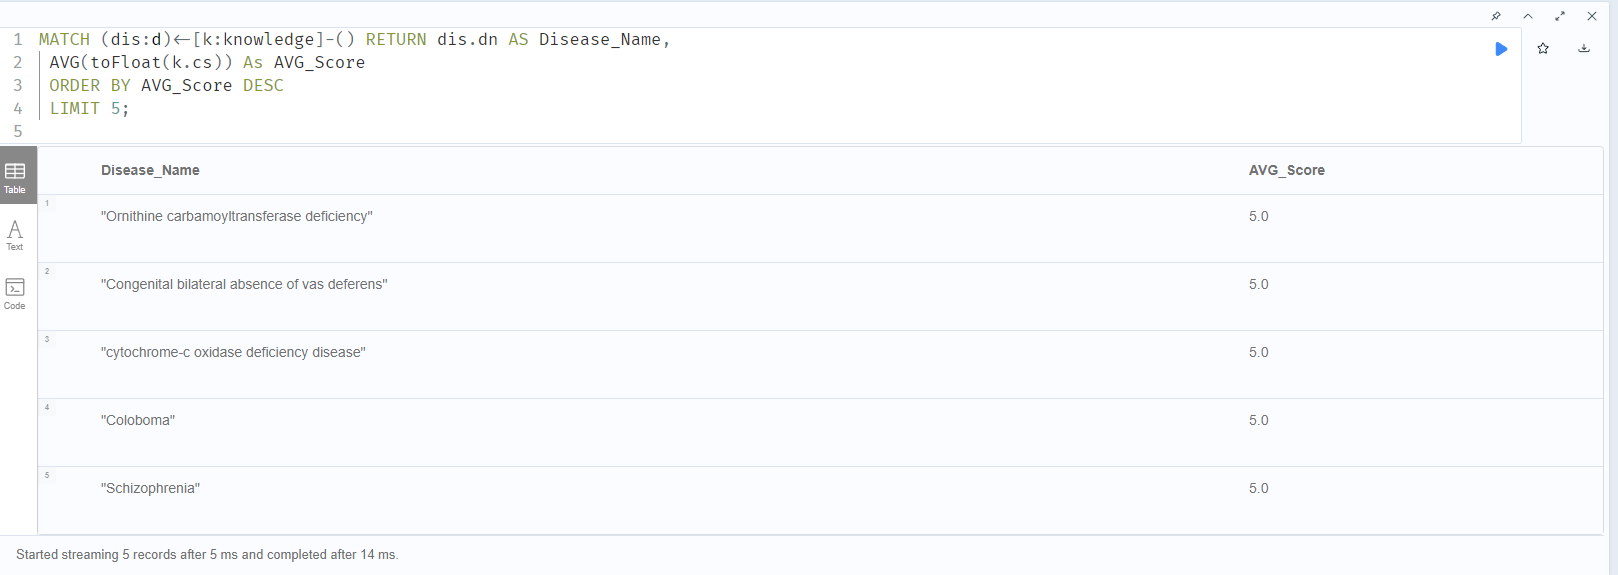

In [93]:
Image(filename=('knowledge_filtered_5disease_1.png'))

In [97]:
q= '''
// number of unique diseases with confidence score =5
MATCH (dis:disease)<-[k:knowledge]-() 
WITH  AVG(toFloat(k.cs)) As AVG_Score, dis.dn AS Disease_Name
 WHERE toInteger(AVG_Score)=5
 RETURN COUNT( Distinct Disease_Name);
'''
conn.query(q)

[<Record COUNT( Distinct Disease_Name)=912>]

Therefore, there are 912 disease with the knowledge confience score of 5. We can display 50 gene nodes connected to the 5 diseaseswith maxium average confidence scores:


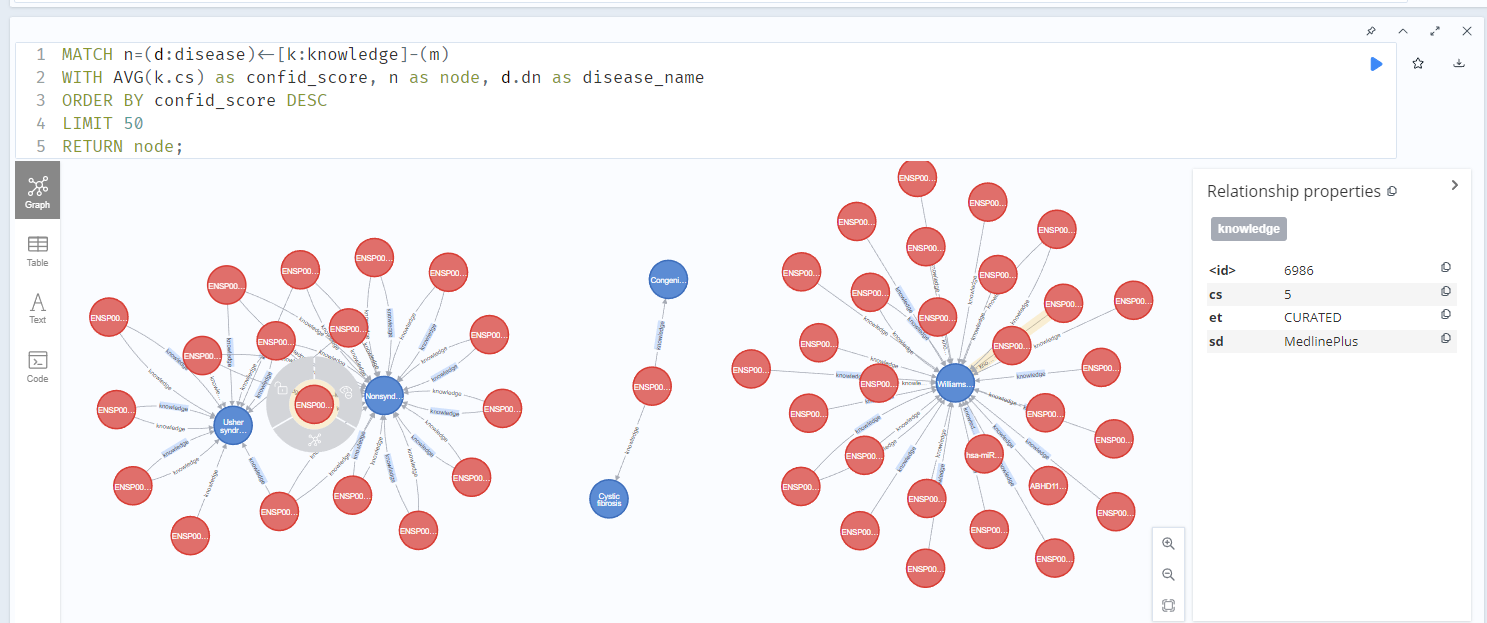

In [20]:
Image(filename=('knowledge_filtered_50.png'))

For the full csv file, we can load the entries in chunck using the automatic periodic call. We've used 500 as the chunk size.

In [ ]:
q='''
:auto
LOAD CSV FROM "file:///c:/human_disease_knowledge_full.tsv" AS row
FIELDTERMINATOR '\t'
CALL {
     // NOTE regarding the header/keys
     //  GENE_IDENTIFIER:gi=row[0] , 
     //  GENE_NAME:gn= row[1] ,
     //  DISEASE_IDENTIFIER:di = row[2],
     //  DISEASE_NAME:dn=row[3],
     //  SOURCE_DATABASE:sd =row[4],
     //  EVIDENCE_TYPE:et=row[5],
     //  CONFIDENCE_SCORE:cs= toInteger(row[6])
     WITH row
     CREATE (g:gene {gi:row[0], gn:row[1]})
     WITH row , g
     CREATE (d:disease {di:row[2], dn:row[3]})
     WITH g,d,row
     CREATE (g)-[k:knowledge{sd:row[4], et:row[5], cs:toInteger(row[6])}]->(d)}
 IN TRANSACTIONS OF 500 ROWS
'''
conn.query(q)

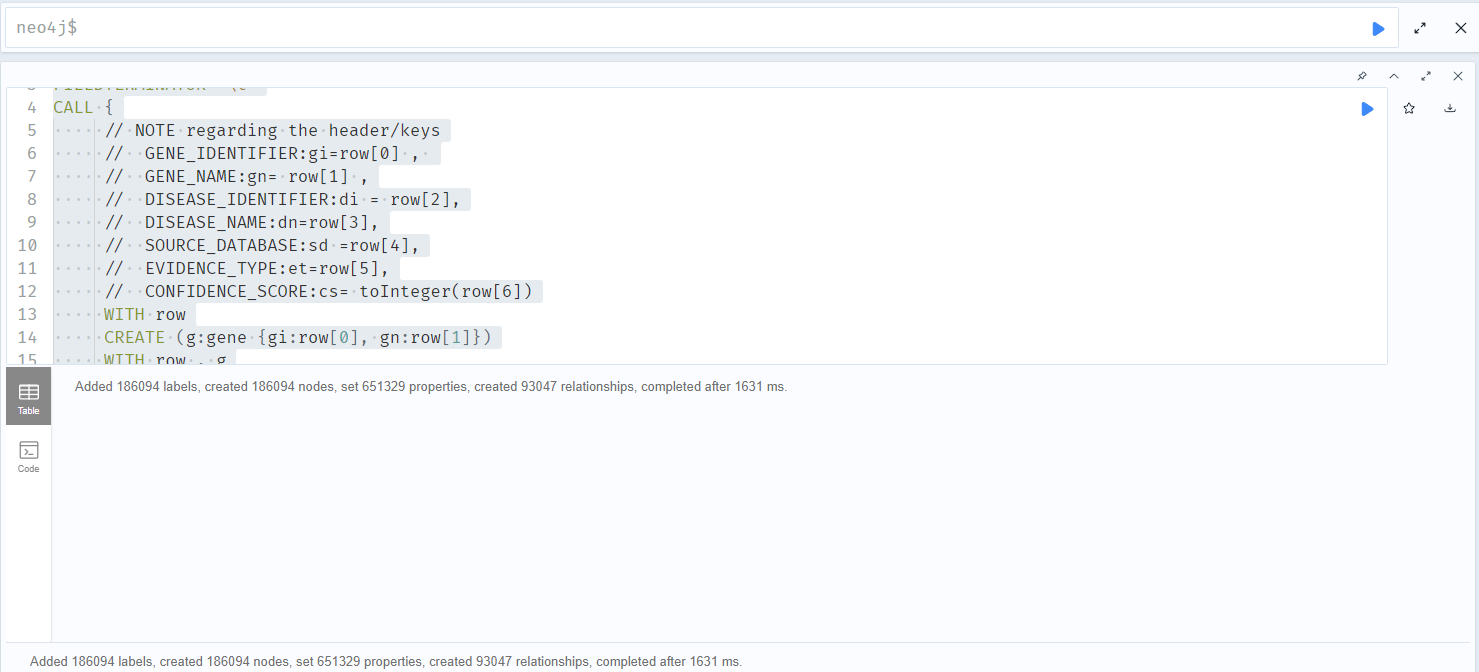

In [21]:
Image(filename=('full_loading_knowledge.png'))

There are 187193 and 189754 unique disease and gene nodes, respectively for the full knowlege csv file.

### Experiments files: 
Now let's try to follow the same query execution with the experiment and text mining csv files. For this purpose, either we can merge nodes with the existing nodes and create new edges or start from scratch. I've created a new 

Note the confidence score and z scores are float numbers (unlike the knowledge files)

In [100]:
q ='''
LOAD CSV FROM "file:///c:/human_disease_experiments_filtered.tsv" AS row
FIELDTERMINATOR '\t'

     // NOTE regarding the header/keys
     //  GENE_IDENTIFIER:gi=row[0] , 
     //  GENE_NAME:gn= row[1] ,
     //  DISEASE_IDENTIFIER:di = row[2],
     //  DISEASE_NAME:dn=row[3],
     //  SOURCE_DATABASE:sd =row[4],
     //  SOURCE_SCORE:et=row[5],
     //  CONFIDENCE_SCORE:cs= toFloat(row[6])
MERGE (g:gene {gi:row[0], gn:row[1]}) 
WITH row , g
MERGE (d:disease {di:row[2], dn:row[3]})
WITH g,d,row
MERGE (g)-[k:experiment{sd:row[4],ss:row[5], cs:toFloat(row[6])}]->(d);
'''
conn.query(q)

[]

In [101]:
q = '''
MATCH n=(d:disease) <-[]-() 
RETURN Distinct n;
'''
conn.query(q)

[<Record n=<Path start=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:72' labels=frozenset({'disease'}) properties={'di': 'DOID:1928', 'dn': 'Williams-Beuren syndrome'}> end=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:3729' labels=frozenset({'gene'}) properties={'gi': 'ENSP00000378577', 'gn': 'CLDN3'}> size=1>>,
 <Record n=<Path start=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:72' labels=frozenset({'disease'}) properties={'di': 'DOID:1928', 'dn': 'Williams-Beuren syndrome'}> end=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:2331' labels=frozenset({'gene'}) properties={'gi': 'ENSP00000336740', 'gn': 'LIMK1'}> size=1>>,
 <Record n=<Path start=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:72' labels=frozenset({'disease'}) properties={'di': 'DOID:1928', 'dn': 'Williams-Beuren syndrome'}> end=<Node element_id='4:ebc07c02-1330-474a-9989-2d1393640488:2466' labels=frozenset({'gene'}) properties={'gi': 'ENSP00000342434', 'gn': 'BAZ1B'}>

In [15]:
q = '''
MATCH (dis:disease) 
RETURN count (DISTINCT dis)
'''


In [16]:
q='''
MATCH (g:gene) 
RETURN count (DISTINCT g)
'''
conn.query(q)

For experiment file, the number of unique disease and gene nodes are  286, 8618, respectively.
Number of disease nodes: 286
Number of gene: 8618b

We can now pick 10 GENENE nodes with the max confidence score connected to the disease nodes

In [ ]:
q='''
MATCH n=(d:disease)<-[e:experiment]-(m)
WITH AVG(e.cs) as confid_score, n as node, d.dn as disease_name
ORDER BY confid_score DESC
LIMIT 10 
RETURN node;
'''
conn.query(q)

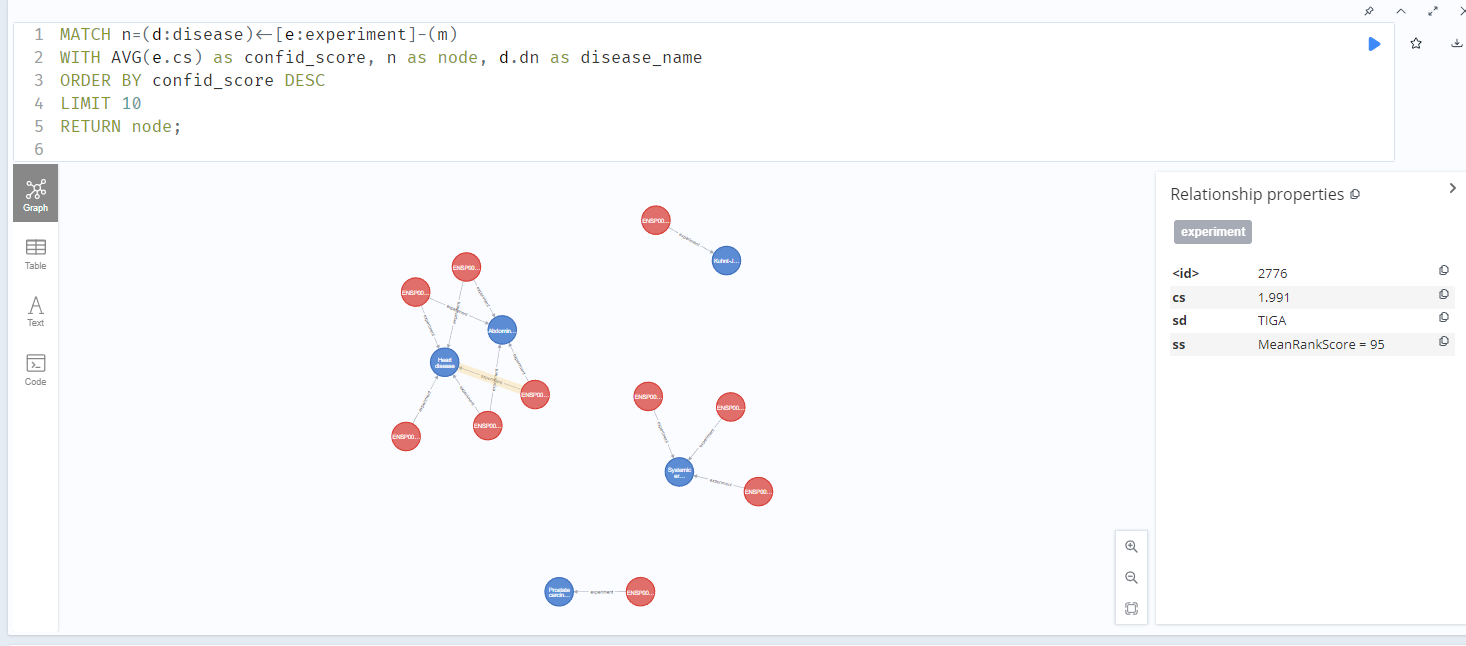

In [19]:
Image(filename=('experiment_10gene.png'))

For the new data we can obtain the top 5 confidence score disease as follows

In [111]:
q= '''
MATCH (dis:disease)<-[e:experiment]-() 
WITH dis.dn AS Disease_Name,
    AVG(toFloat(e.cs)) AS AVG_Score,
    e.ss AS Source_Score,
    e.sd AS Source_Database
 ORDER BY AVG_Score DESC
 WHERE AVG_Score is not null


 RETURN Distinct Disease_Name, AVG_Score
LIMIT 5;
'''
conn.query(q)

[<Record Disease_Name='Exfoliation syndrome' AVG_Score=2.06625>,
 <Record Disease_Name='Gout' AVG_Score=2.066>,
 <Record Disease_Name='Lung carcinoma' AVG_Score=2.065>,
 <Record Disease_Name='Hypothyroidism' AVG_Score=2.063>,
 <Record Disease_Name='Abdominal obesity-metabolic syndrome 1' AVG_Score=2.0629166666666663>]

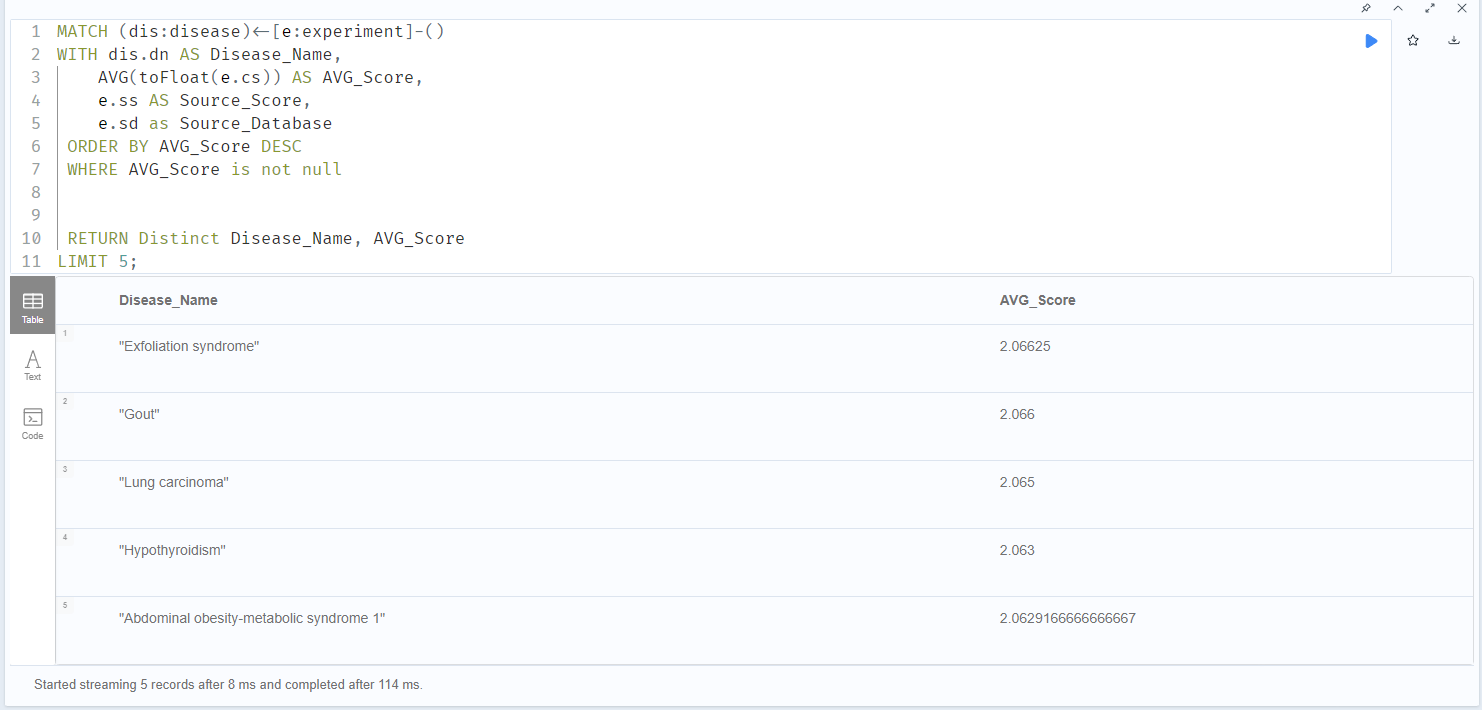

In [18]:
from IPython.display import Image
Image(filename=('experiment_cs5.png'))

In [ ]:
q = '''
MATCH n=(dis:disease) <-[e:experiment]-() 
WHERE (e.cs >=2)
RETURN Distinct n;
'''
conn.query(q)

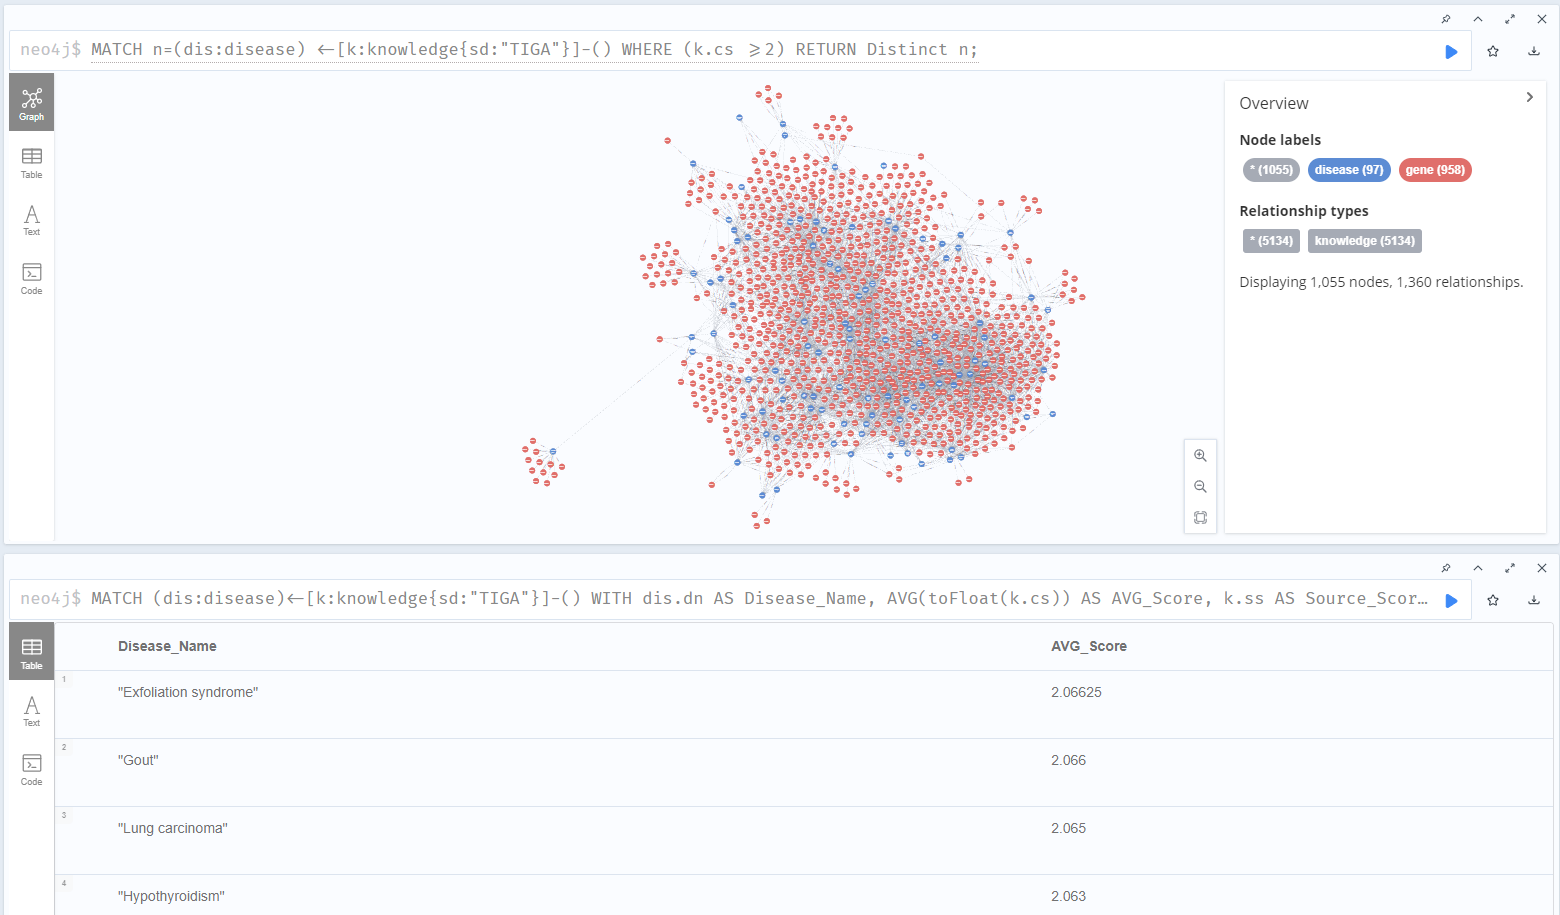

In [2]:
Image(filename=('./experiment_csg2.png'))

Now we can load and execute the filtered mining csv file. We can remove all the nodes first to make sure we can start from scratch:

In [ ]:
q =''' 
MATCH (n)
DETACH DELETE n
'''


In [3]:
q = '''
 LOAD CSV FROM "file:///c:/human_disease_textmining_filtered.tsv" AS row
 FIELDTERMINATOR '\t'
// NOTE regarding the header/keys
     //  GENE_IDENTIFIER:gi=row[0] , 
     //  GENE_NAME:gn= row[1] ,
     //  DISEASE_IDENTIFIER:di = row[2],
     //  DISEASE_NAME:dn=row[3],
     //  Z_score:zs =toFloat(row[4]),
     //  CONFIDENCE_SCORE:cs= toFloat(row[5]),
     // URL_dource:url=row[6]
MERGE (g:gene {gi:row[0], gn:row[1]}) 
WITH row , g
MERGE (d:disease {di:row[2], dn:row[3]})
WITH g,d,row
MERGE (g)-[m:mining{zs:toFloat(row[4]), cs:toFloat(row[5]), url:(row[6])}]->(d); 
'''

that took a long time to load a large file! I've used periodic call instead to load csv file in batches of 500 chunks. I've also removed the source URL from the edges. 

Note CREATE command will create nodes from scratch with not checking whether they exist or not. Therefoer, CREATE is faster than MATCH but would not MERGE nodes to the exisiting graphdata base. 

In [4]:
q = '''
:auto
LOAD CSV FROM "file:///c:/human_disease_textmining_filtered.tsv" AS row
FIELDTERMINATOR '\t'
CALL {
               // NOTE regarding the header/keys
                    //  GENE_IDENTIFIER:gi=row[0] , 
                    //  GENE_NAME:gn= row[1] ,
                    //  DISEASE_IDENTIFIER:di = row[2],
                    //  DISEASE_NAME:dn=row[3],
                    //  Z_score:zs =toFloat(row[4]),
                    //  CONFIDENCE_SCORE:cs= toFloat(row[5]),
                    // URL_dource:url=row[6] we can elimiate url for now
               WITH row
               CREATE (g:gene {gi:row[0], gn:row[1]}) 
               WITH row , g
               CREATE (d:disease {di:row[2], dn:row[3]})
               WITH g,d,row
               CREATE (g)-[m:mining{zs:toFloat(row[4]), cs:toFloat(row[5])}]->(d)}
               IN TRANSACTIONS OF 500 ROWS
'''
conn.query(q)

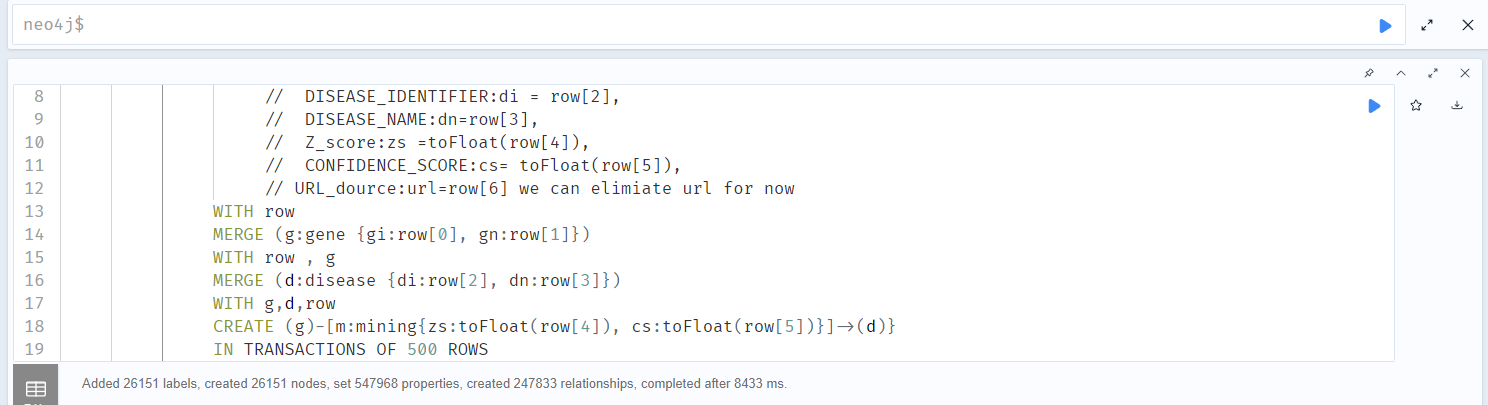

In [6]:
Image(filename=('mining_filtered_0.png'))

So now we've created 26151 unique nodes gpt the disease-gene nodes extarted by mining. WE've added the edges with z-scores and cofidence scores. As it can be seen, it took 8 seconds to load near half million entries. 

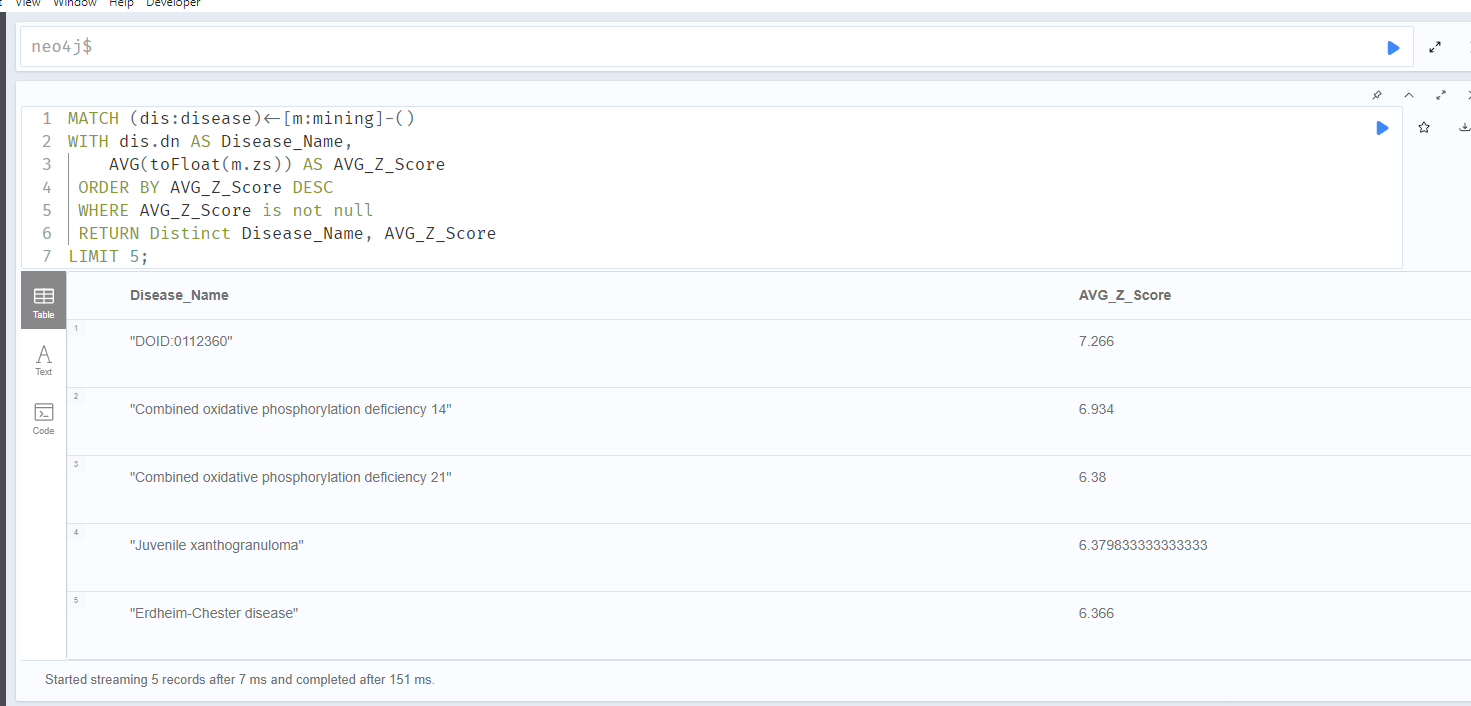

In [8]:
Image(filename=('mining_zscore_1.png'))

Now we can present the nodes with the top 50 average z_scores as follows

In [ ]:
q= '''
MATCH n=(dis:disease) <-[m:mining]-()
WITH m.zs as zscore, n as node
ORDER BY zscore DESC
LIMIT 10
RETURN node;
'''
conn.query(q)

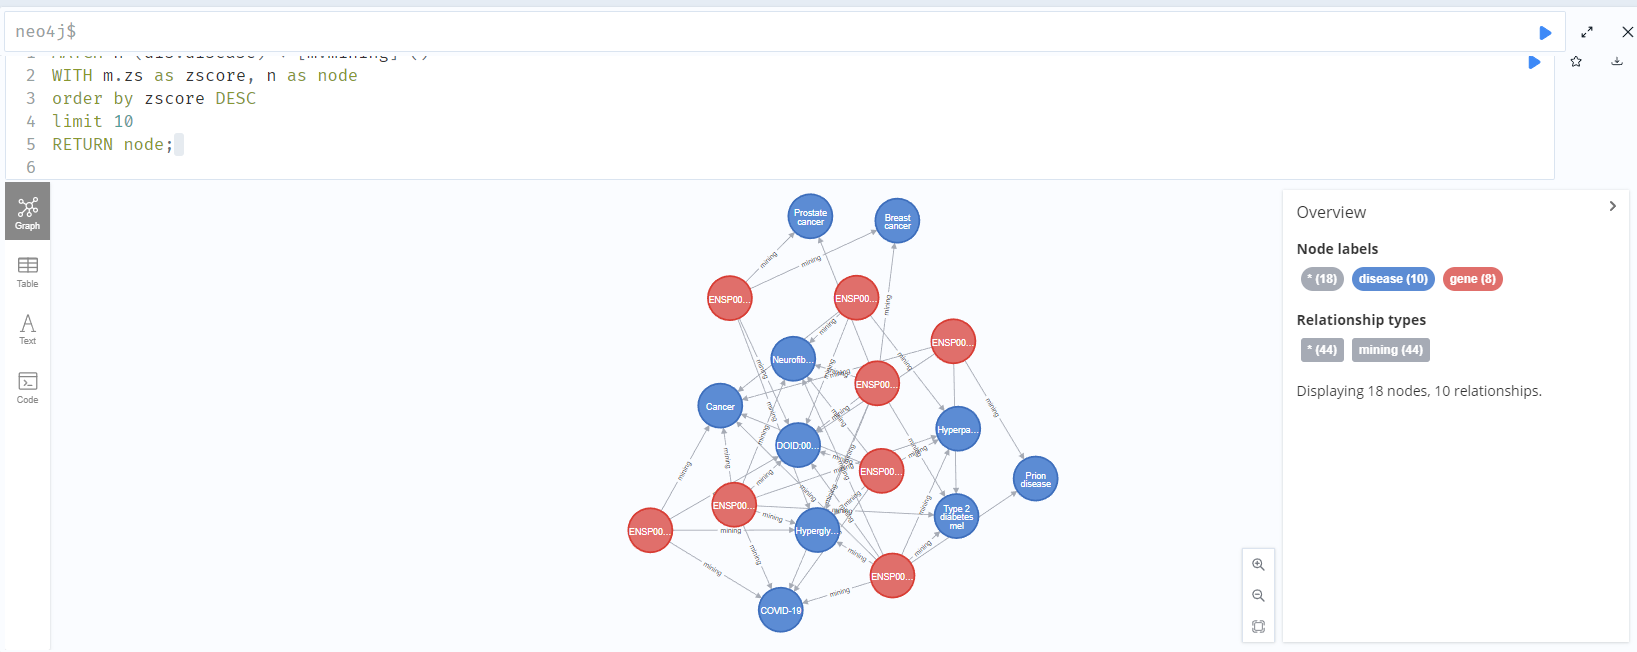

In [12]:
Image(filename=('zscore_10.png'))

We can also order them based on confidence score times z_score. However, based on the article, there are related.

In [ ]:
q= '''
MATCH n=(dis:disease) <-[m:mining]-()
WITH m.zs as zscore,m.cs as confid_score, n as node
ORDER BY zscore*confid_score DESC
LIMIT 10
RETURN node;
'''
conn.query(q)

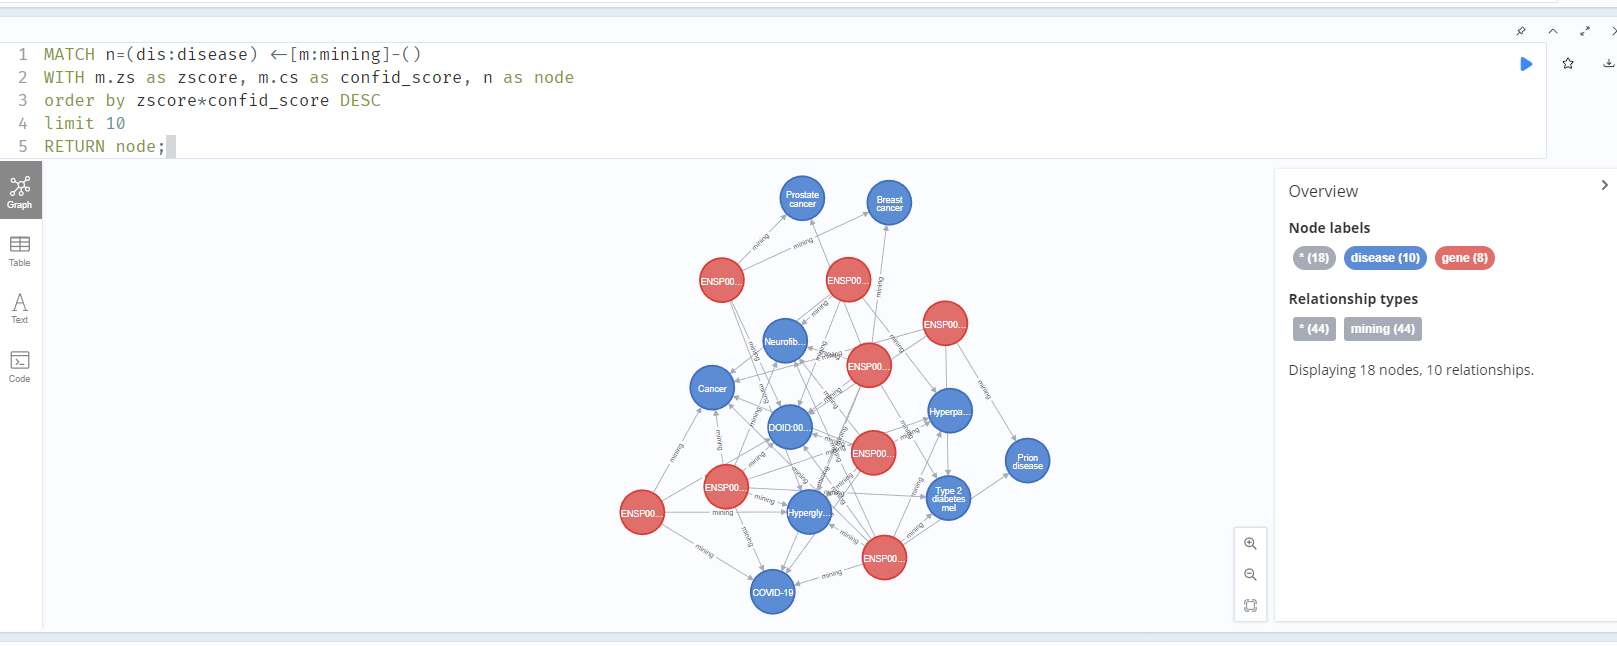

In [13]:
Image(filename=('zxc_score_10.png'))

As it can be seen, the last two graphs are identical as expeded owing to the fact that z_score and confidence scores are related.
